In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../Data/all_rating.csv')
data.head()

,product_id,content,customer_id,user_name,stars,comment_id
0,58441480,"Giao hàng nhanh , sách đẹp .Giao hôm qua hn Ti...",7201105,Hải Phạm,5,4702781
1,58441480,"Nội dung hay, Phụ huynh nên đọc để định hướng ...",823195,Trang Nguyen,5,4940437
2,58441480,Sách hay dành cho cả người lớn và trẻ nhỏ. Hìn...,6927758,Luyen Do,4,4690057
3,58441480,sách quá đẹp đi! nội dung rất ok,73375,Hiểu Mai,5,4645307
4,58441480,Sách đẹp,7103521,Nguyễn Xuân Hùng,5,4627799


In [33]:
data.shape

(267627, 6)

In [8]:
# check for the duplicate records
data.drop_duplicates(['product_id', 'customer_id', 'stars'], inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267627 entries, 0 to 267741
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   product_id   267627 non-null  int64 
 1   content      179790 non-null  object
 2   customer_id  267627 non-null  int64 
 3   user_name    266936 non-null  object
 4   stars        267627 non-null  int64 
 5   comment_id   267627 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 24.3+ MB


## Split data

In [10]:
split_value = int(len(data) * 0.80)
train_data = data[:split_value]
test_data = data[split_value:]

## Analysis of Data

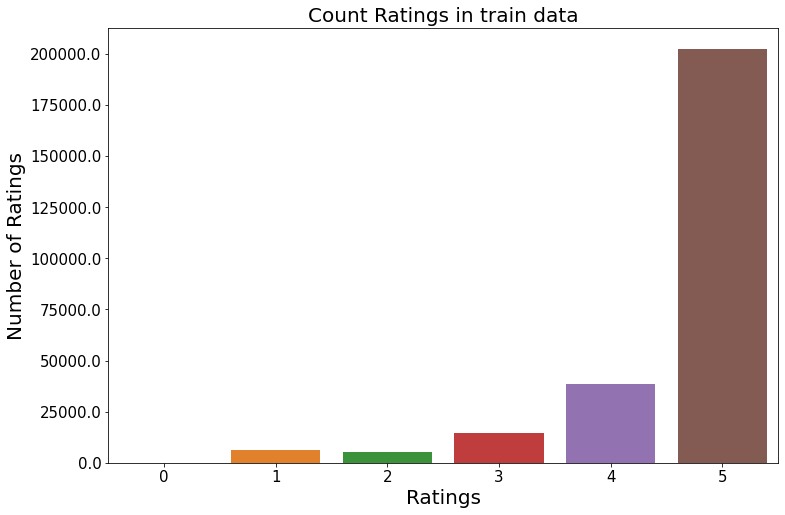

In [11]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="stars", data=data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

## Create User-Item Sparse Matrix

In [27]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


In [13]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.stars, (df.customer_id, df.product_id)))
    return sparse_data

Create Sparse Matrix from the Training Dataset, Testing Datatset

In [17]:
train_sparse_data = get_user_item_sparse_matrix(train_data)
test_sparse_data = get_user_item_sparse_matrix(test_data)

Find Average Gloabal Rating of Movie    

In [18]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 4.602623146842041


A Generic Method to Calculate Average Rating from Sparse Matrix

In [19]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [20]:
# Calculate Average User Rating
average_rating_user = get_average_rating(train_sparse_data, True)

In [21]:
# Calcualte Average Book Rating
avg_rating_book = get_average_rating(train_sparse_data, False)

## Check Cold Start Problem for Users
Here, 18% of total users are new and they will have no proper rating available. So, this can bring the issue of the cold start problems.

In [22]:
total_users = len(np.unique(data["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 148336
No. of Users in train data= 122257
No. of Users not present in train data = 26079(18.0%)


## Check Cold Start Problem for Books
Here, 33% of total movies are new and their rating might not be available in the dataset. So, this can bring the issue of the cold start problems.

In [24]:
total_books = len(np.unique(data["product_id"]))
train_books = len(avg_rating_book)
uncommonBooks = total_books- train_books
                  
print("Total no. of Movies = {}".format(total_books))
print("No. of Movies in train data= {}".format(train_books))
print("No. of Movies not present in train data = {}({}%)".format(uncommonBooks, np.round((uncommonBooks/total_books)*100), 2))

Total no. of Movies = 9674
No. of Movies in train data= 6447
No. of Movies not present in train data = 3227(33.0%)


## Computation of user similarity to find similarities of top 100 users

In [39]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(12225700).reshape(122257,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr


In [38]:
row_index, col_index = train_sparse_data.nonzero()
print(row_index)
print(col_index)
np.unique(row_index).shape

[       0       27       27 ... 18745367 18745645 18745711]
[  316388  1934401 27957162 ... 68690875 12207665 12207665]


(122257,)

In [40]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [42]:
similar_user_matrix[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Load Movie Titles

In [43]:
book_titles_df = pd.read_csv("../Data/clean_books.csv")
book_titles_df.head()

,id,sku,name,url_path,book_cover,short_description,price,list_price,price_usd,discount,...,rating_average,review_count,order_count,favourite_count,thumbnail_url,productset_group_name,description,publisher,authors,stock_item
0,58390336,3380735508079,Python cơ bản,python-co-ban-p58390336.html?spid=58390337,Bìa mềm,SÁCH PYTHON CƠ BẢN\r\nHiện nay ngôn ngữ lập tr...,125000,125000,5.343,0,...,4.8,32,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Sách Công Nghệ Thông Tin, Lập Trình",sách python cơ_bản ngôn_ngữ lập_trình bậc pyth...,NXB Đại Học Quốc Gia Hà Nội,Bùi Việt Hà,5.0
1,1664525,2147399986992,Giáo Trình Kỹ Thuật Lập Trình C Căn Bản Và Nân...,giao-trinh-ky-thuat-lap-trinh-c-can-ban-va-nan...,Bìa mềm,Giáo trình kỹ thuật lập trình C căn bản và nân...,67500,135000,2.885,67500,...,4.5,82,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Sách Công Nghệ Thông Tin, Lập Trình",giáo_trình kỹ_thuật lập_trình căn_bản nâng hìn...,Huy Hoàng Bookstore,Nhiều Tác Giả,801.0
2,55573620,6752050391860,Giáo Trình Tự Học AutoCAD 2019 Thực Hành Bằng ...,giao-trinh-tu-hoc-autocad-2019-thuc-hanh-bang-...,Bìa mềm,Mục lục:\r\nCHƯƠNG 1: BẮT ĐẦU AUTOCAD 2019 \r\...,110000,110000,4.702,0,...,4.7,10,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Sách Công Nghệ Thông Tin, Thiết Kế - Đồ Họa",mục_lục chương autocad chương kỹ_năng cơ_bản c...,Công Ty TNHH Văn Hóa - Thế Giới Sách Việt,Nhiều Tác Giả,12.0
3,24889348,3747885152000,Lập trình hướng đối tượng JAVA core dành cho n...,lap-trinh-huong-doi-tuong-java-core-danh-cho-n...,NaN,I. Đôi điều về tác giả\r\nTôi là NEOS.THÀNH (N...,189000,299000,8.079,110000,...,4.7,86,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Sách Công Nghệ Thông Tin, Lập Trình",đôi tác_giả neos thành nguyễn văn thành lập_tr...,-,"Tiki hoàn tiền 111% nếu phát hiện hàng giả, Ca...",NaN
4,37667006,5950833882104,Combo Giáo Trình Kỹ Thuật Lập Trình C Căn Bản ...,combo-giao-trinh-ky-thuat-lap-trinh-c-can-ban-...,Bìa mềm,Giáo trình kỹ thuật lập trình C căn bản và nân...,223400,280000,9.550,56600,...,4.3,21,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Sách Công Nghệ Thông Tin, Lập Trình",giáo_trình kỹ_thuật lập_trình căn_bản nâng hìn...,Huy Hoàng Bookstore,Nhiều Tác Giả,97.0


In [51]:
book_titles_df.loc[0][2]

'Python cơ bản'

## Compute Book Similarity Matrix

In [52]:
def compute_book_similarity_count(sparse_matrix, book_titles_df, book_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_books = book_titles_df.loc[book_id][2], similarity[book_id].count_nonzero()
    return no_of_similar_books

In [55]:
similar_books = compute_book_similarity_count(train_sparse_data, book_titles_df, 1)
print("Similar Books = {}".format(similar_books))

Similar Books = ('Giáo Trình Kỹ Thuật Lập Trình C Căn Bản Và Nâng Cao', 0)


## Create Sample Sparse Matrix
This method will be used to generate Sample Sparse Matrix. New similarity features will be generated from this sample sparse matrix.

In [ ]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(user)+1, max(movie)+1))
    return sparse_matrix